# Proyecto Final

## Generacion de Arte

#### Manuel Rodas 21509
#### Sebastian Solorzano 
#### Jose Santisteban

In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Dense, Flatten, Reshape, Conv2D, Conv2DTranspose, BatchNormalization, LeakyReLU, Dropout # type: ignore
from tensorflow.keras.optimizers import Adam # type: ignore
from tensorflow.keras.preprocessing.image import load_img, img_to_array # type: ignore
from tensorflow.keras.mixed_precision import set_global_policy # type: ignore
from tensorflow.keras.preprocessing.image import load_img, img_to_array # type: ignore
from PIL import UnidentifiedImageError
import matplotlib.pyplot as plt

In [ ]:
# Configuración
IMG_HEIGHT = 32
IMG_WIDTH = 32
IMG_CHANNELS = 3
LATENT_DIM = 100
EPOCHS = 1000
BATCH_SIZE = 32
DATASET_PATH = './NORMAL'

In [ ]:
def load_images(dataset_path):
    images = []
    for file_name in os.listdir(dataset_path):
        file_path = os.path.join(dataset_path, file_name)
        try:
            # Intentar cargar la imagen
            img = load_img(file_path, target_size=(IMG_HEIGHT, IMG_WIDTH))
            img_array = img_to_array(img)
            img_array = (img_array - 127.5) / 127.5  # Normalizar a rango [-1, 1]
            images.append(img_array)
        except UnidentifiedImageError:
            print(f"Advertencia: No se pudo identificar el archivo {file_path}. Se omitirá.")
        except Exception as e:
            print(f"Error al procesar el archivo {file_path}: {e}")
    return np.array(images)

images = load_images(DATASET_PATH)[:500]

In [ ]:
def build_generator():
    model = tf.keras.Sequential([
        Dense(4 * 4 * 256, input_dim=LATENT_DIM),
        BatchNormalization(),
        LeakyReLU(),
        Reshape((4, 4, 256)),
        Conv2DTranspose(128, kernel_size=4, strides=2, padding='same', kernel_initializer='he_normal'),
        BatchNormalization(),
        LeakyReLU(),
        Conv2DTranspose(64, kernel_size=4, strides=2, padding='same', kernel_initializer='he_normal'),
        BatchNormalization(),
        LeakyReLU(),
        Conv2DTranspose(IMG_CHANNELS, kernel_size=4, strides=2, padding='same', activation='tanh')
    ])
    return model

In [ ]:
# Creación del Discriminador
def build_discriminator():
    model = tf.keras.Sequential([
        Conv2D(64, kernel_size=4, strides=2, padding='same', input_shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS),
               kernel_initializer='he_normal'),
        BatchNormalization(),
        LeakyReLU(),
        Dropout(0.3),
        Conv2D(128, kernel_size=4, strides=2, padding='same', kernel_initializer='he_normal'),
        BatchNormalization(),
        LeakyReLU(),
        Dropout(0.3),
        Flatten(),
        Dense(1, activation='sigmoid')
    ])
    return model

In [ ]:
# Construcción de las redes
generator = build_generator()
discriminator = build_discriminator()
discriminator.compile(optimizer=Adam(0.0002, 0.5), loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
# Creación del modelo combinado
discriminator.trainable = False
gan_input = tf.keras.Input(shape=(LATENT_DIM,))
generated_image = generator(gan_input)
gan_output = discriminator(generated_image)
gan = tf.keras.Model(gan_input, gan_output)
gan.compile(optimizer=Adam(0.0002, 0.5), loss='binary_crossentropy')

In [82]:
def save_and_plot_generated_images(epoch, generator, examples=5):
    noise = np.random.normal(0, 1, (examples, LATENT_DIM))
    generated_images = generator.predict(noise)
    
    # Escalar de [-1, 1] a [0, 1]
    generated_images = 0.5 * generated_images + 0.5  # Escalar a [0, 1]
    
    # Asegurarse de que las imágenes estén en el tipo correcto
    generated_images = np.clip(generated_images, 0.0, 1.0)  # Limitar los valores entre 0 y 1
    generated_images = (generated_images * 255).astype(np.uint8)  # Convertir a uint8

    plt.figure(figsize=(10, 5))
    for i, img in enumerate(generated_images):
        plt.subplot(1, examples, i + 1)
        plt.imshow(img)
        plt.axis('off')
    plt.tight_layout()
    plt.savefig(f"generated_images_epoch_{epoch}.png")
    plt.show()

In [83]:
# Entrenamiento de la GAN
def train_gan(epochs, batch_size):
    real_labels = np.ones((batch_size, 1))
    fake_labels = np.zeros((batch_size, 1))
    
    for epoch in range(epochs):
        # Entrenar el discriminador
        idx = np.random.randint(0, images.shape[0], batch_size)
        real_images = images[idx]
        noise = np.random.normal(0, 1, (batch_size, LATENT_DIM))
        fake_images = generator.predict(noise)
        
        d_loss_real = discriminator.train_on_batch(real_images, real_labels)
        d_loss_fake = discriminator.train_on_batch(fake_images, fake_labels)
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
        
        # Entrenar el generador
        noise = np.random.normal(0, 1, (batch_size, LATENT_DIM))
        g_loss = gan.train_on_batch(noise, real_labels)
        
        # Mostrar progreso
        if epoch % 100 == 0:
            print(f"Epoch {epoch}, D Loss: {d_loss[0]}, D Acc: {d_loss[1]}, G Loss: {g_loss}")
        
        # Guardar e imprimir imágenes cada 1000 épocas
        if epoch % 100 == 0 and epoch > 0:
            save_and_plot_generated_images(epoch, generator)

In [84]:
print(f"Dataset shape: {images.shape}")
print(f"Min pixel value: {np.min(images)}, Max pixel value: {np.max(images)}")

Dataset shape: (500, 32, 32, 3)
Min pixel value: -1.0, Max pixel value: 1.0


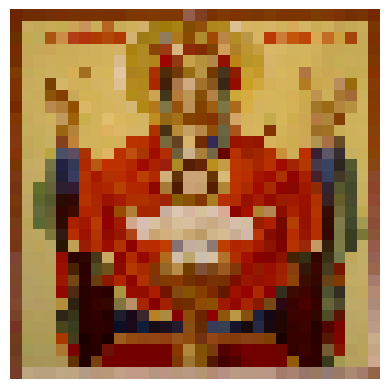

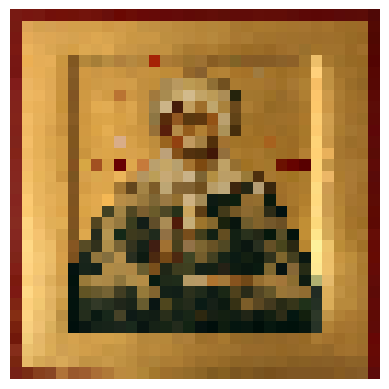

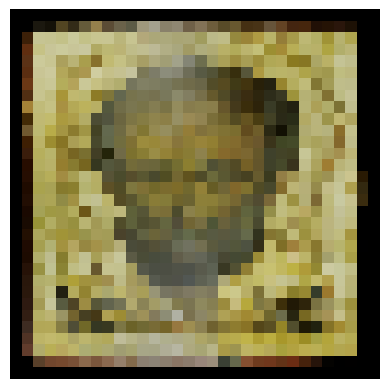

In [85]:
import matplotlib.pyplot as plt
for i in range(3):
    plt.imshow((images[i] + 1) / 2)  # Convertir de rango [-1, 1] a [0, 1]
    plt.axis('off')
    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 596ms/step
Epoch 0, D Loss: 0.803277313709259, D Acc: 0.546875, G Loss: [array(0.75007224, dtype=float32), array(0.75007224, dtype=float32), array(0.625, dtype=float32)]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 488ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 448ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 423ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 419ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 418ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 421ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 422ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 448ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 415ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 432ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 427ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 415ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 424ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 414ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 453ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 433ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 415ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 417ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 425ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 423ms/step
1/1 ━━━━━━━━━━━━━━━━━━

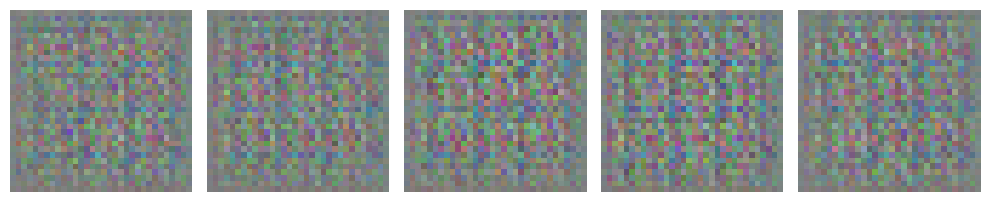

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 479ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 466ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 471ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 489ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 424ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 539ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 459ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 427ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 435ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 434ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 425ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 420ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 429ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 422ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 428ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 435ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 447ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 448ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 435ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 442ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 435ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 440ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 432ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 430ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

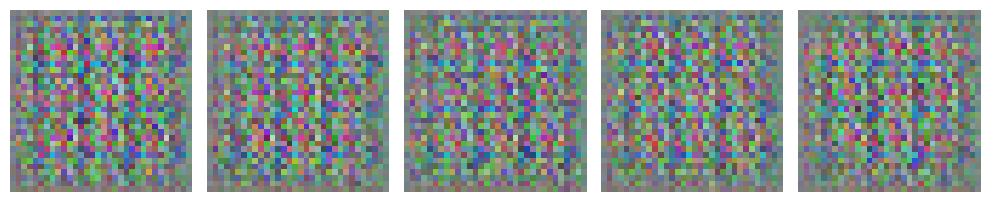

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 444ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 425ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 480ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 433ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 467ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 497ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 452ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 452ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 482ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 493ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 643ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 530ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 440ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 426ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 418ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 419ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 451ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 493ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 474ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 518ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 472ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 512ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 490ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 509ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 424ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

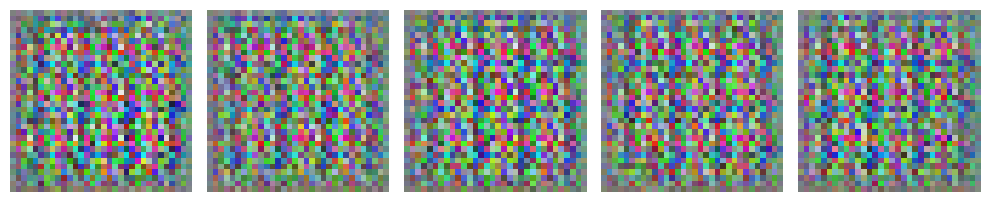

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 473ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 450ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 460ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 463ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 468ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 573ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 456ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 461ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 460ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 497ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 465ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 454ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 490ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 466ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 444ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 443ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 464ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 501ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 446ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 442ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 472ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 450ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 440ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 486ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 456ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

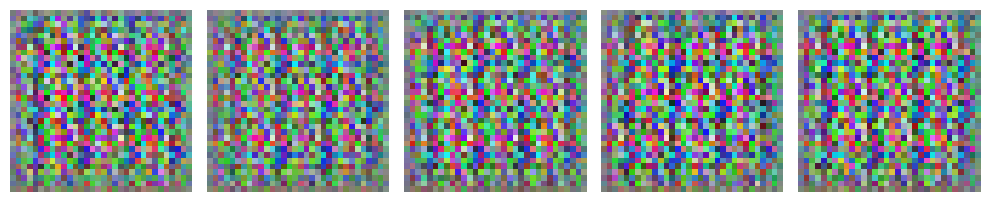

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 481ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 454ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 585ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 455ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 469ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 471ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 451ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 464ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 487ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 521ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 458ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 462ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 450ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 512ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 462ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 601ms/step


KeyboardInterrupt: 

In [86]:
# Entrenar la GAN
train_gan(EPOCHS, BATCH_SIZE)